In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'drive/MyDrive/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


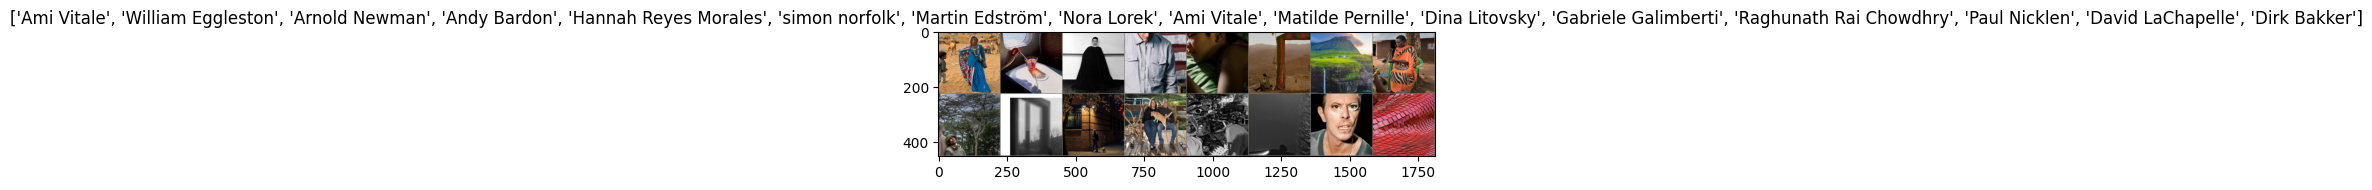

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    #best_model_wts = copy.deepcopy(model_.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 48)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 44.8MB/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


  3%|▎         | 7/205 [01:17<33:40, 10.20s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [32:34<00:00,  9.54s/it]


train Loss: 3.3073 Acc: 0.1691


100%|██████████| 51/51 [02:59<00:00,  3.51s/it]


test Loss: 2.8140 Acc: 0.2654

Epoch 1/9
----------


 93%|█████████▎| 190/205 [30:07<02:20,  9.39s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [32:17<00:00,  9.45s/it]


train Loss: 2.3278 Acc: 0.3881


100%|██████████| 51/51 [02:58<00:00,  3.50s/it]


test Loss: 2.5891 Acc: 0.3062

Epoch 2/9
----------


 68%|██████▊   | 140/205 [22:32<10:28,  9.68s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [32:34<00:00,  9.54s/it]


train Loss: 1.9174 Acc: 0.4766


100%|██████████| 51/51 [02:50<00:00,  3.35s/it]


test Loss: 2.4132 Acc: 0.3432

Epoch 3/9
----------


 89%|████████▉ | 183/205 [29:00<03:25,  9.33s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [32:16<00:00,  9.45s/it]


train Loss: 1.6583 Acc: 0.5418


100%|██████████| 51/51 [02:58<00:00,  3.50s/it]


test Loss: 2.2695 Acc: 0.3852

Epoch 4/9
----------


 13%|█▎        | 26/205 [04:22<28:24,  9.52s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [32:33<00:00,  9.53s/it]


train Loss: 1.4428 Acc: 0.5856


100%|██████████| 51/51 [02:48<00:00,  3.31s/it]


test Loss: 2.2473 Acc: 0.4012

Epoch 5/9
----------


 15%|█▍        | 30/205 [04:42<26:28,  9.08s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [32:01<00:00,  9.37s/it]


train Loss: 1.3308 Acc: 0.6291


100%|██████████| 51/51 [02:53<00:00,  3.41s/it]


test Loss: 2.2854 Acc: 0.3889

Epoch 6/9
----------


 66%|██████▋   | 136/205 [21:42<11:08,  9.69s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [32:29<00:00,  9.51s/it]


train Loss: 1.1815 Acc: 0.6689


100%|██████████| 51/51 [02:54<00:00,  3.43s/it]


test Loss: 2.2395 Acc: 0.4210

Epoch 7/9
----------


 62%|██████▏   | 127/205 [20:24<11:49,  9.09s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [32:32<00:00,  9.53s/it]


train Loss: 0.9589 Acc: 0.7412


100%|██████████| 51/51 [02:52<00:00,  3.39s/it]


test Loss: 2.1607 Acc: 0.4296

Epoch 8/9
----------


 21%|██        | 43/205 [07:03<26:35,  9.85s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [32:34<00:00,  9.53s/it]


train Loss: 0.9537 Acc: 0.7391


100%|██████████| 51/51 [03:01<00:00,  3.55s/it]


test Loss: 2.1319 Acc: 0.4469

Epoch 9/9
----------


 17%|█▋        | 34/205 [05:31<25:52,  9.08s/it]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
 47%|████▋     | 97/205 [15:30<16:53,  9.38s/it]

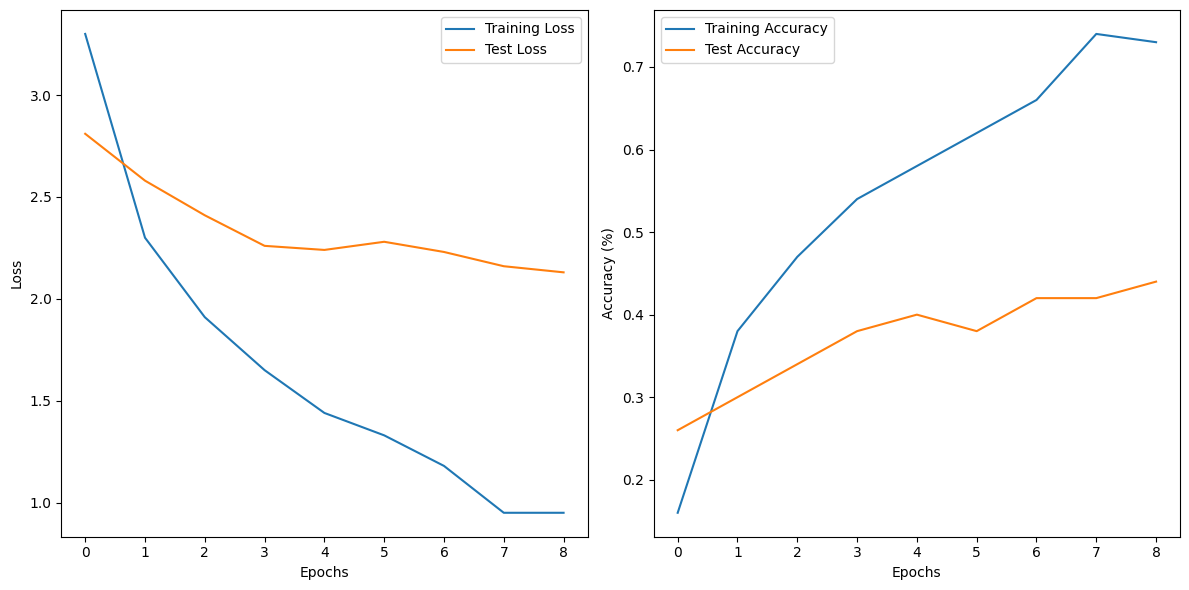

In [ ]:
import matplotlib.pyplot as plt

# Example data for losses and accuracies
training_losses = [3.30, 2.30, 1.91, 1.65, 1.44, 1.33, 1.18, 0.95,0.95]
test_losses = [2.81, 2.58, 2.41, 2.26, 2.24, 2.28, 2.23, 2.16, 2.13,]
training_accuracies = [0.16,0.38,0.47,0.54,0.58,0.62,0.66,0.74,0.73]
test_accuracies = [0.26,0.30,0.34,0.38,0.40,0.38,0.42,0.42,0.44,]

# Plotting
plt.figure(figsize=(12, 6))

# Plot Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

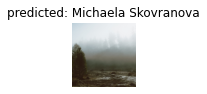

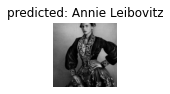

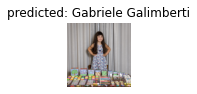

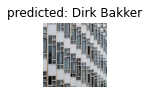

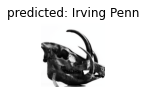

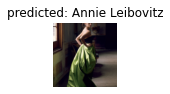

In [ ]:
visualize_model(model_ft)

In [ ]:
!pip install scikit-learn

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


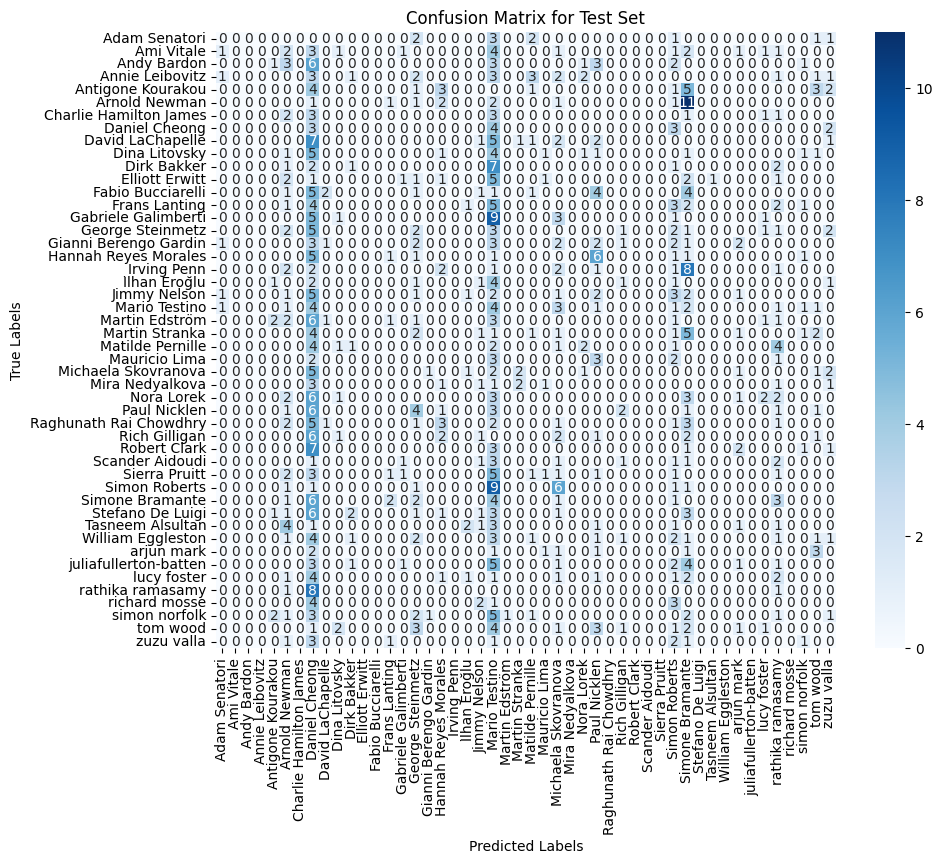

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Import numpy

def compute_confusion_matrix(model):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Save confusion matrix to a file
    np.savetxt("resnet34_confusion_matrix.csv", conf_matrix, delimiter=",")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Compute and plot the confusion matrix
compute_confusion_matrix(model_ft)

In [ ]:
import numpy as np
import pandas as pd
import os

# Load confusion matrix CSV (48x48)
cm = np.loadtxt("resnet34_confusion_matrix.csv", delimiter=",")

# Check shape to confirm 48 classes
num_classes = cm.shape[0]
print(f"Confusion matrix shape: {cm.shape}")

if num_classes != 48:
    raise ValueError("Confusion matrix is not 48x48!")

# Replace this with your actual list of 48 class names in correct order
class_names = [
    "Adam Senatori", "Ami Vitale", "Andy Bardon", "Annie Leibovitz", "Antigone Kourakou",
    "Arnold Newman", "Charlie Hamilton James", "Daniel Cheong", "David LaChapelle", "Dina Litovsky",
    "Dirk Bakker", "Elliott Erwitt", "Fabio Bucciarelli", "Frans Lanting", "Gabriele Galimberti",
    "George Steinmetz", "Gianni Berengo Gardin", "Hannah Reyes Morales", "Irving Penn", "İlhan Eroğlu",
    "Jimmy Nelson", "Mario Testino", "Martin Edström", "Martin Stranka", "Matilde Pernille",
    "Mauricio Lima", "Michaela Skovranova", "Mira Nedyalkova", "Nora Lorek", "Paul Nicklen",
    "Raghunath Rai Chowdhry", "Rich Gilligan", "Robert Clark", "Scander Aidoudi", "Sierra Pruitt",
    "Simon Roberts", "Simone Bramante", "Stefano De Luigi", "Tasneem Alsultan", "William Eggleston",
    "Arjun Mark", "Julia Fullerton-Batten", "Lucy Foster", "Rathika Ramasamy", "Richard Mosse",
    "Simon Norfolk", "Tom Wood", "Zuzu Valla"
]

if len(class_names) != 48:
    raise ValueError("class_names list does not contain 48 names!")

# Calculate TP, FP, FN, TN
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

# Calculate precision, recall, f1-score
epsilon = 1e-10
precision = TP / (TP + FP + epsilon)
recall = TP / (TP + FN + epsilon)
f1 = 2 * precision * recall / (precision + recall + epsilon)

# Create DataFrame for results
results = pd.DataFrame({
    'Class': class_names,
    'TP': TP,
    'FP': FP,
    'FN': FN,
    'TN': TN,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Set class names as index if you prefer
results.set_index('Class', inplace=True)

# Save to CSV
results.to_csv("class_metrics_resnet34.csv")

# Print first 10 rows to check
print(results.head(48))


Confusion matrix shape: (48, 48)
                         TP     FP    FN     TN  Precision    Recall  F1-Score
Class                                                                         
Adam Senatori           0.0    5.0  10.0  795.0   0.000000  0.000000  0.000000
Ami Vitale              0.0    0.0  19.0  791.0   0.000000  0.000000  0.000000
Andy Bardon             0.0    0.0  20.0  790.0   0.000000  0.000000  0.000000
Annie Leibovitz         0.0    0.0  20.0  790.0   0.000000  0.000000  0.000000
Antigone Kourakou       0.0    7.0  20.0  783.0   0.000000  0.000000  0.000000
Arnold Newman           0.0   40.0  20.0  750.0   0.000000  0.000000  0.000000
Charlie Hamilton James  0.0    0.0  11.0  799.0   0.000000  0.000000  0.000000
Daniel Cheong           3.0  179.0   9.0  619.0   0.016484  0.250000  0.030928
David LaChapelle        0.0    5.0  20.0  785.0   0.000000  0.000000  0.000000
Dina Litovsky           0.0    7.0  17.0  786.0   0.000000  0.000000  0.000000
Dirk Bakker        

<Figure size 2200x1000 with 0 Axes>

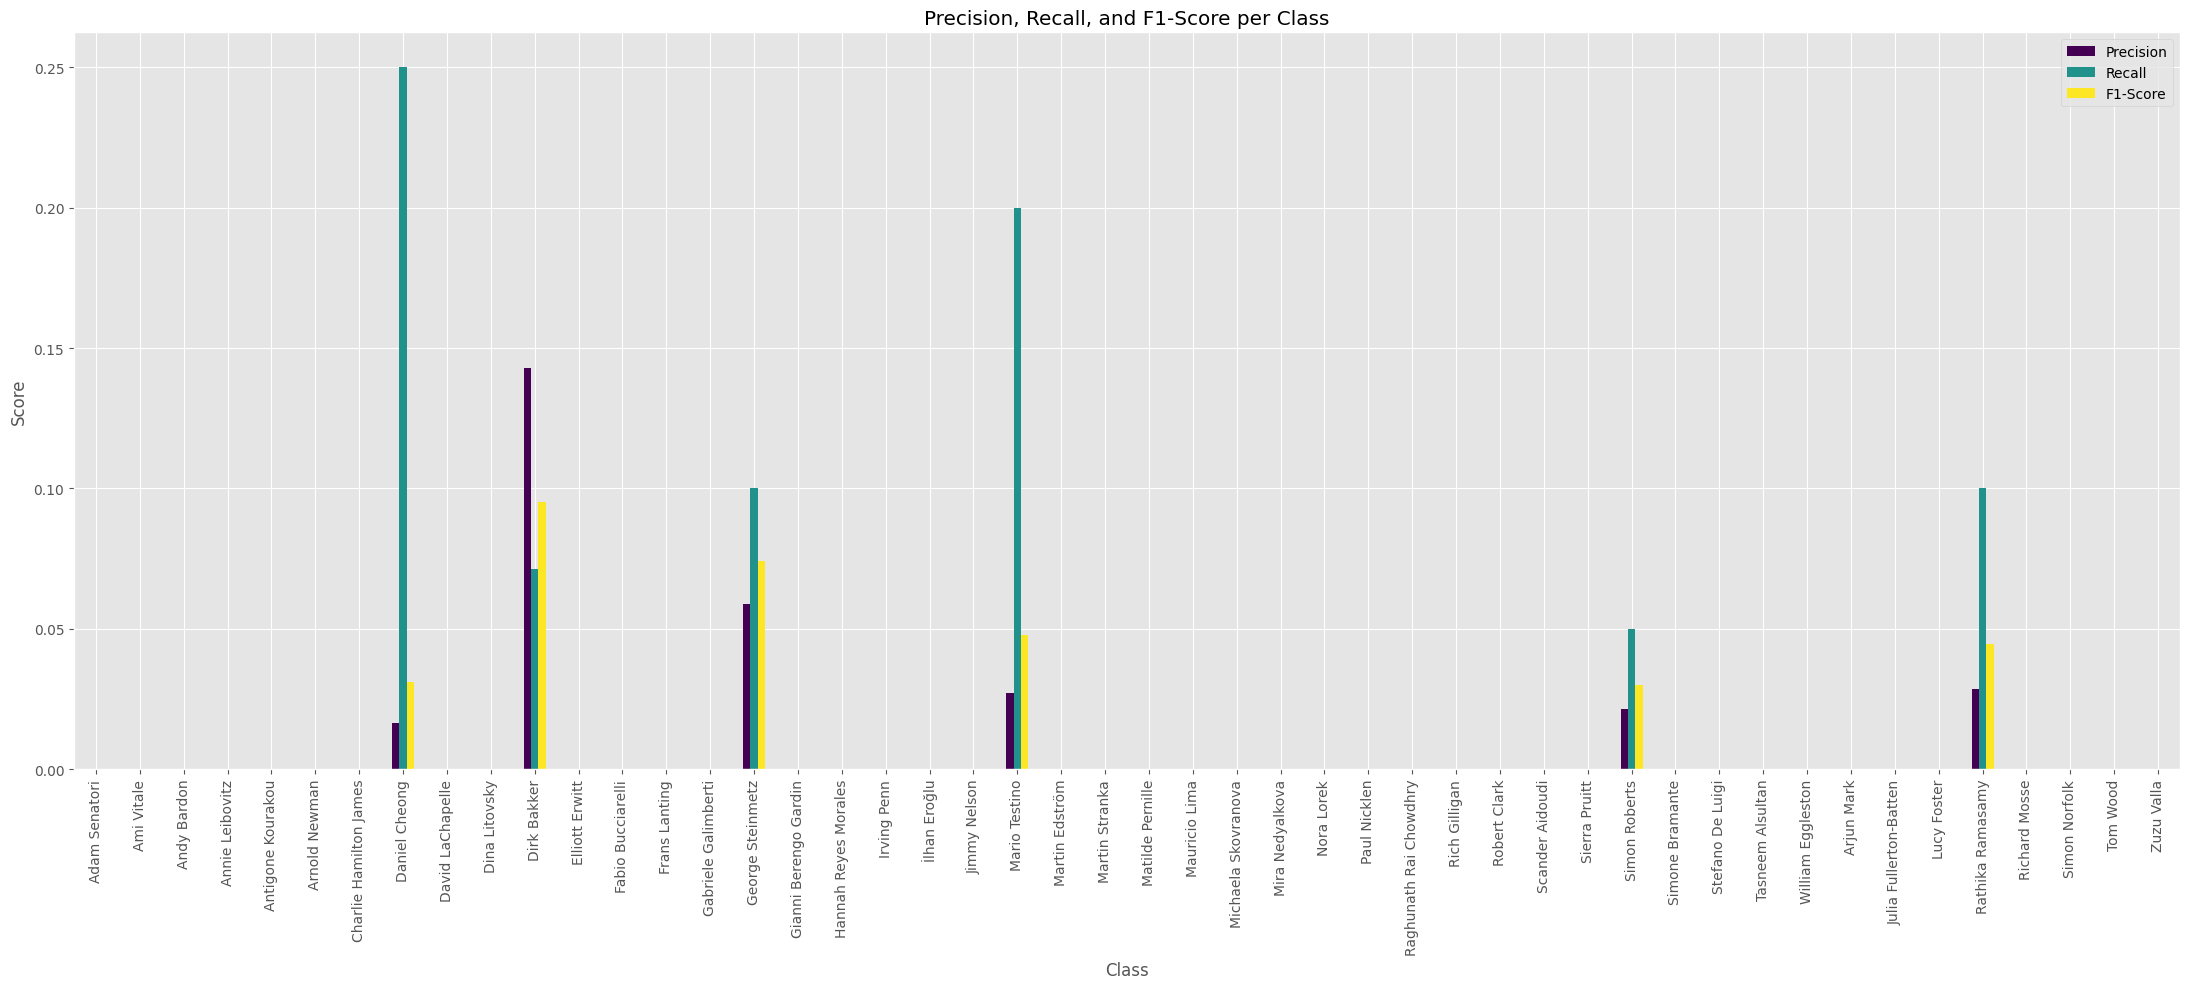

In [ ]:
plt.figure(figsize=(22, 10))
metrics = ['Precision', 'Recall', 'F1-Score']
results_plot = results[metrics]

results_plot.plot(kind='bar', figsize=(22, 10), colormap='viridis')
plt.xticks(rotation=90)
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score per Class')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
model_conv = torchvision.models.resnet34(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 48)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


  0%|          | 0/205 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 85%|████████▌ | 175/205 [05:07<00:51,  1.73s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [05:56<00:00,  1.74s/it]


train Loss: 3.6220 Acc: 0.0983


100%|██████████| 51/51 [01:24<00:00,  1.66s/it]


test Loss: 3.3630 Acc: 0.1531

Epoch 1/9
----------


 34%|███▎      | 69/205 [02:06<03:53,  1.71s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [05:59<00:00,  1.75s/it]


train Loss: 2.9745 Acc: 0.2570


100%|██████████| 51/51 [01:24<00:00,  1.65s/it]


test Loss: 3.0032 Acc: 0.2370

Epoch 2/9
----------


 93%|█████████▎| 190/205 [05:35<00:25,  1.72s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [05:58<00:00,  1.75s/it]


train Loss: 2.6548 Acc: 0.3329


100%|██████████| 51/51 [01:24<00:00,  1.66s/it]


test Loss: 2.8371 Acc: 0.2704

Epoch 3/9
----------


 86%|████████▌ | 176/205 [05:07<00:49,  1.72s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [05:54<00:00,  1.73s/it]


train Loss: 2.4201 Acc: 0.3865


100%|██████████| 51/51 [01:27<00:00,  1.71s/it]


test Loss: 2.7392 Acc: 0.2901

Epoch 4/9
----------


 84%|████████▍ | 173/205 [05:02<00:55,  1.73s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [05:55<00:00,  1.73s/it]


train Loss: 2.3006 Acc: 0.4080


100%|██████████| 51/51 [01:24<00:00,  1.66s/it]


test Loss: 2.6890 Acc: 0.2926

Epoch 5/9
----------


 47%|████▋     | 96/205 [02:51<03:10,  1.75s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [05:58<00:00,  1.75s/it]


train Loss: 2.1907 Acc: 0.4279


100%|██████████| 51/51 [01:24<00:00,  1.65s/it]


test Loss: 2.6157 Acc: 0.3235

Epoch 6/9
----------


 41%|████▏     | 85/205 [02:30<03:27,  1.73s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [05:57<00:00,  1.74s/it]


train Loss: 2.1036 Acc: 0.4475


100%|██████████| 51/51 [01:24<00:00,  1.65s/it]


test Loss: 2.6035 Acc: 0.3136

Epoch 7/9
----------


 65%|██████▌   | 134/205 [03:54<02:01,  1.71s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [05:54<00:00,  1.73s/it]


train Loss: 2.0095 Acc: 0.4763


100%|██████████| 51/51 [01:25<00:00,  1.67s/it]


test Loss: 2.5612 Acc: 0.3222

Epoch 8/9
----------


  4%|▍         | 9/205 [00:18<05:47,  1.78s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [05:58<00:00,  1.75s/it]


train Loss: 1.9797 Acc: 0.4910


100%|██████████| 51/51 [01:24<00:00,  1.65s/it]


test Loss: 2.5400 Acc: 0.3383

Epoch 9/9
----------


 16%|█▌        | 33/205 [00:59<04:59,  1.74s/it]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 205/205 [05:58<00:00,  1.75s/it]


train Loss: 1.9752 Acc: 0.4943


100%|██████████| 51/51 [01:24<00:00,  1.65s/it]

test Loss: 2.5286 Acc: 0.3333

Training complete in 73m 40s
Best test Acc: 0.338272


In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

NameError: name 'model_conv' is not defined

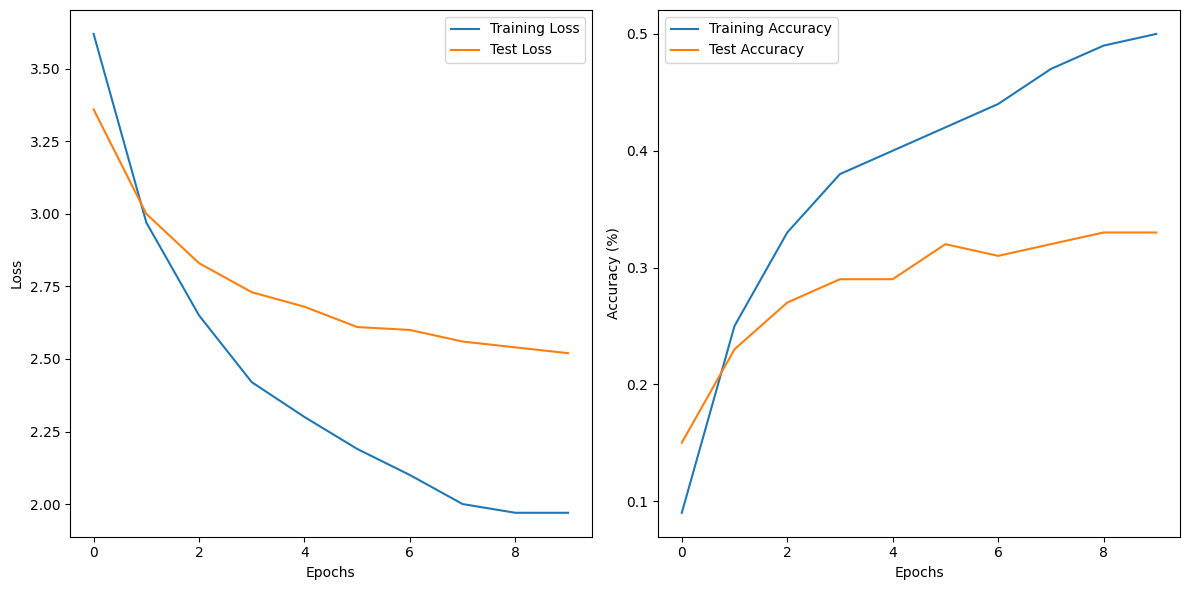

In [ ]:
import matplotlib.pyplot as plt

# Example data for losses and accuracies
training_losses = [3.62, 2.97, 2.65, 2.42, 2.30, 2.19, 2.10, 2.00,1.97,1.97]
test_losses = [3.36, 3.00, 2.83, 2.73, 2.68, 2.61, 2.60, 2.56, 2.54,2.52]
training_accuracies = [0.09,0.25,0.33,0.38,0.40,0.42,0.44,0.47,0.49,0.50]
test_accuracies = [0.15,0.23,0.27,0.29,0.29,0.32,0.31,0.32,0.33,0.33]

# Plotting
plt.figure(figsize=(12, 6))

# Plot Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

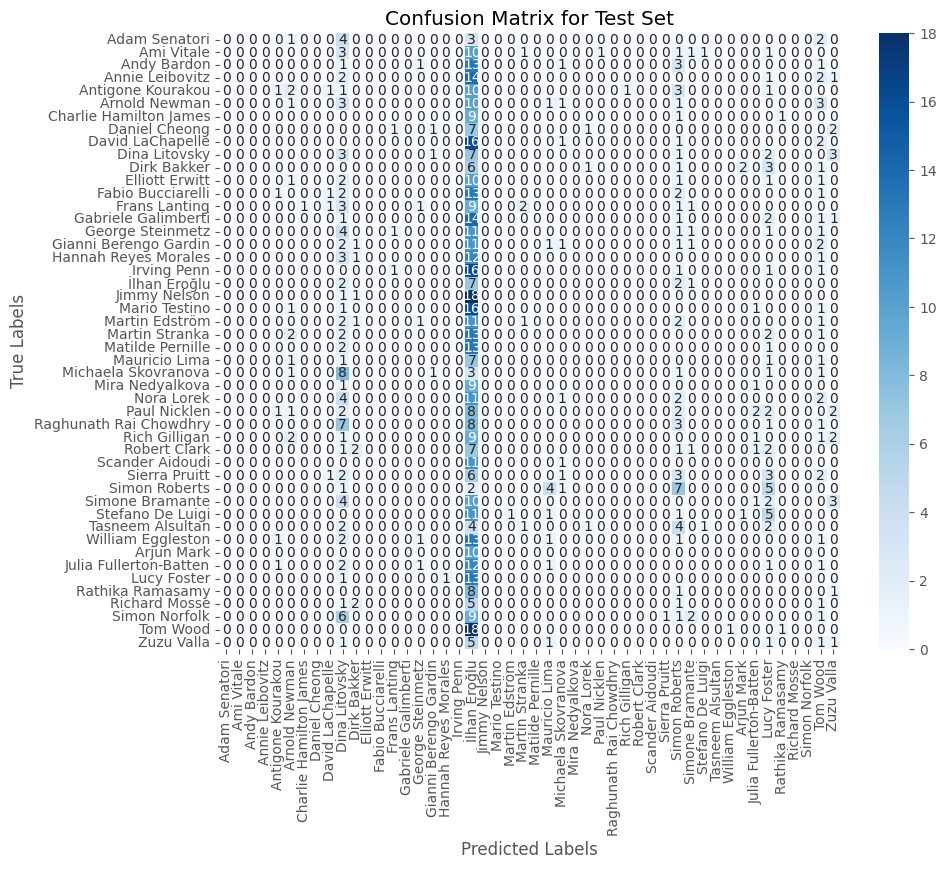

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np



def compute_confusion_matrix(model):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    np.savetxt("resnet34_confusion_matrix.csv", conf_matrix, delimiter=",")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Compute and plot the confusion matrix
compute_confusion_matrix(model_conv)

In [ ]:
import numpy as np
import pandas as pd
import os

# Load confusion matrix CSV (48x48)
cm = np.loadtxt("resnet34_confusion_matrix.csv", delimiter=",")

# Check shape to confirm 48 classes
num_classes = cm.shape[0]
print(f"Confusion matrix shape: {cm.shape}")

if num_classes != 48:
    raise ValueError("Confusion matrix is not 48x48!")

# Replace this with your actual list of 48 class names in correct order
class_names = [
    "Adam Senatori", "Ami Vitale", "Andy Bardon", "Annie Leibovitz", "Antigone Kourakou",
    "Arnold Newman", "Charlie Hamilton James", "Daniel Cheong", "David LaChapelle", "Dina Litovsky",
    "Dirk Bakker", "Elliott Erwitt", "Fabio Bucciarelli", "Frans Lanting", "Gabriele Galimberti",
    "George Steinmetz", "Gianni Berengo Gardin", "Hannah Reyes Morales", "Irving Penn", "İlhan Eroğlu",
    "Jimmy Nelson", "Mario Testino", "Martin Edström", "Martin Stranka", "Matilde Pernille",
    "Mauricio Lima", "Michaela Skovranova", "Mira Nedyalkova", "Nora Lorek", "Paul Nicklen",
    "Raghunath Rai Chowdhry", "Rich Gilligan", "Robert Clark", "Scander Aidoudi", "Sierra Pruitt",
    "Simon Roberts", "Simone Bramante", "Stefano De Luigi", "Tasneem Alsultan", "William Eggleston",
    "Arjun Mark", "Julia Fullerton-Batten", "Lucy Foster", "Rathika Ramasamy", "Richard Mosse",
    "Simon Norfolk", "Tom Wood", "Zuzu Valla"
]

if len(class_names) != 48:
    raise ValueError("class_names list does not contain 48 names!")

# Calculate TP, FP, FN, TN
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

# Calculate precision, recall, f1-score
epsilon = 1e-10
precision = TP / (TP + FP + epsilon)
recall = TP / (TP + FN + epsilon)
f1 = 2 * precision * recall / (precision + recall + epsilon)

# Create DataFrame for results
results = pd.DataFrame({
    'Class': class_names,
    'TP': TP,
    'FP': FP,
    'FN': FN,
    'TN': TN,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Set class names as index if you prefer
results.set_index('Class', inplace=True)

# Save to CSV
results.to_csv("class_metrics_resnet34.csv")

# Print first 10 rows to check
print(results.head(48))


Confusion matrix shape: (48, 48)
                         TP     FP    FN     TN  Precision    Recall  F1-Score
Class                                                                         
Adam Senatori           0.0    0.0  10.0  800.0   0.000000  0.000000  0.000000
Ami Vitale              0.0    0.0  19.0  791.0   0.000000  0.000000  0.000000
Andy Bardon             0.0    0.0  20.0  790.0   0.000000  0.000000  0.000000
Annie Leibovitz         0.0    0.0  20.0  790.0   0.000000  0.000000  0.000000
Antigone Kourakou       1.0    4.0  19.0  786.0   0.200000  0.050000  0.080000
Arnold Newman           1.0   12.0  19.0  778.0   0.076923  0.050000  0.060606
Charlie Hamilton James  0.0    1.0  11.0  798.0   0.000000  0.000000  0.000000
Daniel Cheong           0.0    0.0  12.0  798.0   0.000000  0.000000  0.000000
David LaChapelle        0.0    4.0  20.0  786.0   0.000000  0.000000  0.000000
Dina Litovsky           3.0   88.0  14.0  705.0   0.032967  0.176471  0.055556
Dirk Bakker        

<Figure size 2200x1000 with 0 Axes>

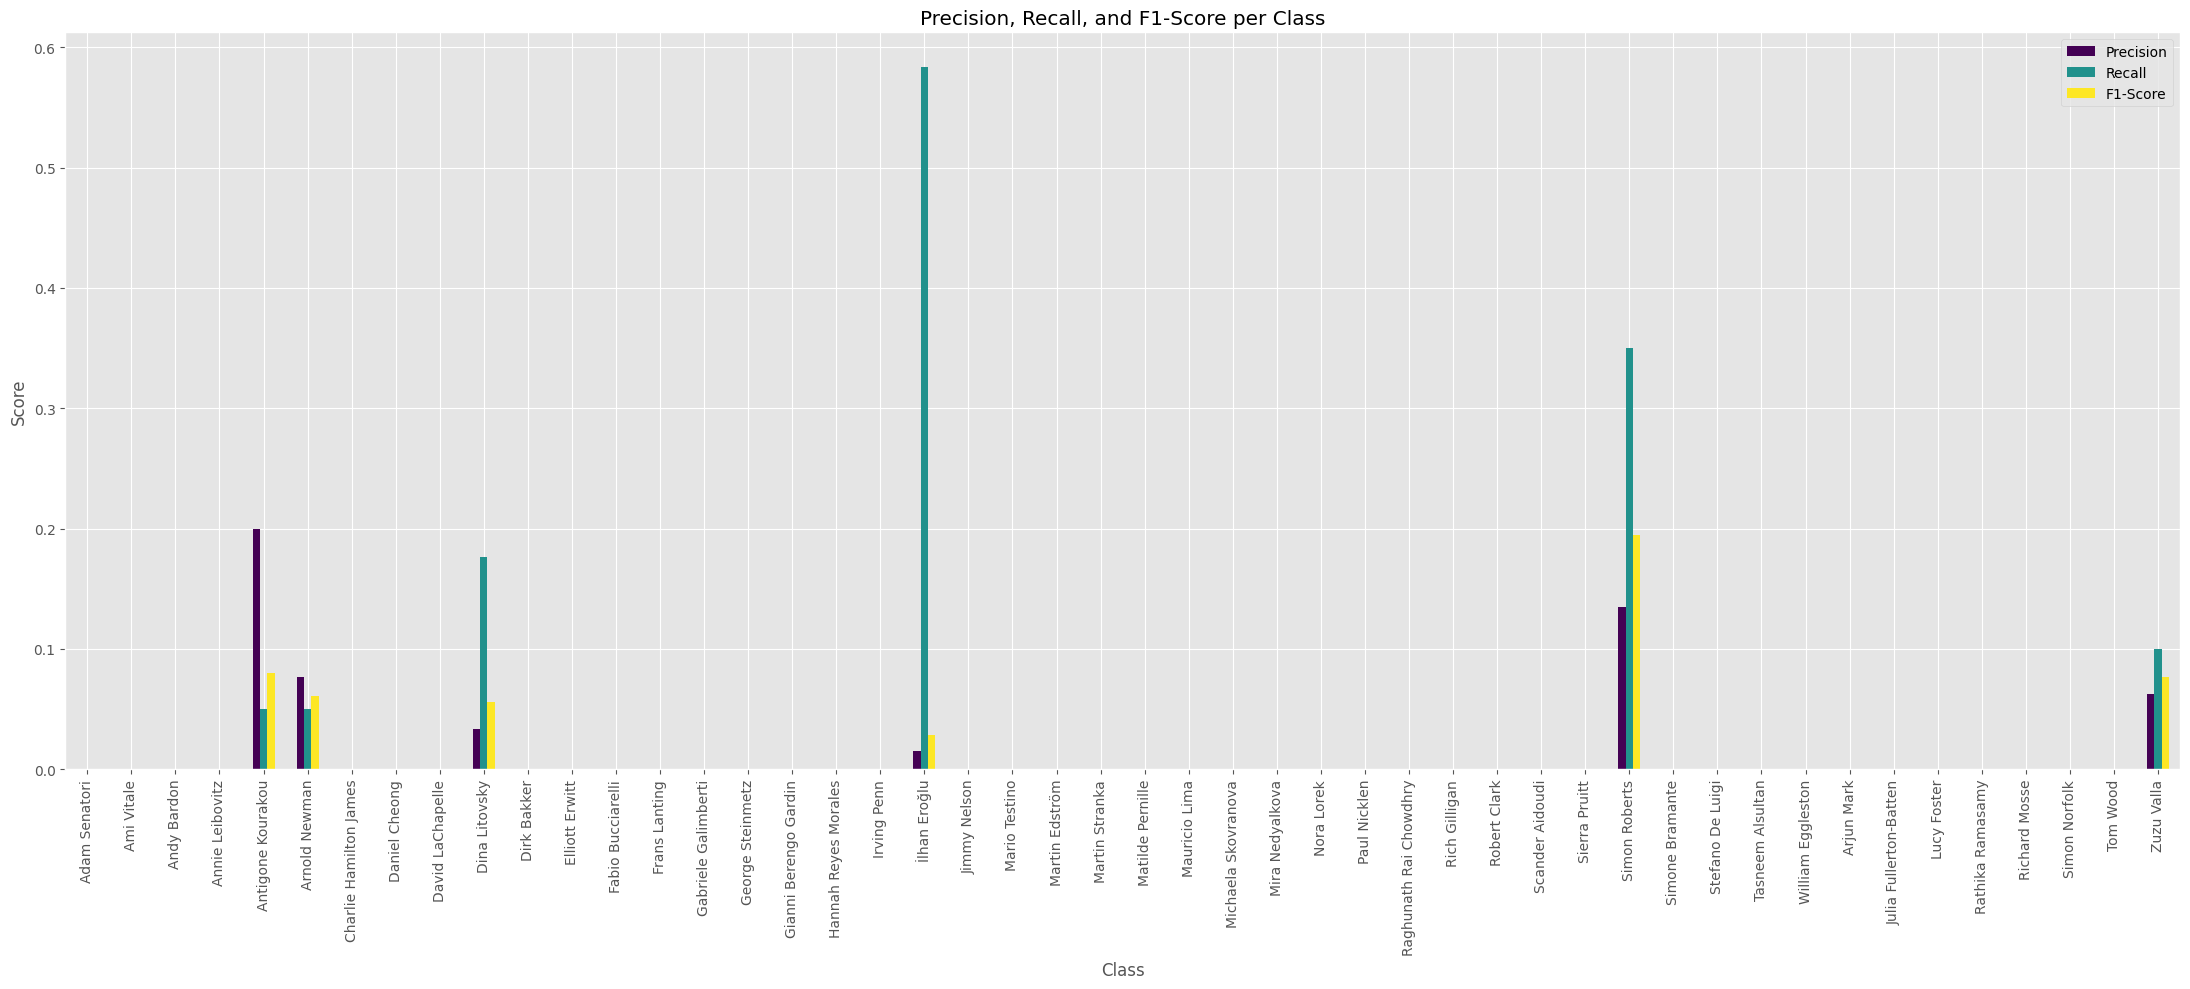

In [ ]:
plt.figure(figsize=(22, 10))
metrics = ['Precision', 'Recall', 'F1-Score']
results_plot = results[metrics]

results_plot.plot(kind='bar', figsize=(22, 10), colormap='viridis')
plt.xticks(rotation=90)
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score per Class')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
